###########################################################################<br>
\# This code is associated to the paper:<br>
\# <b>Provable bounds for noise-free expectation values computed from noisy samples</b><br>
\# (https://arxiv.org/abs/2312.00733)<br>
\# <br>
\# (C) Copyright IBM 2024.<br>
\# <br>
\# Any modifications or derivative works of this code must retain<br>
\# this copyright notice, and modified files need to carry a notice<br>
\# indicating that they have been altered from the originals.<br>
###########################################################################

# 127-qubit QAOA

QAOA for cubic binary optimization problems with 127 binary variables presented in https://arxiv.org/abs/2312.00733. 

Original source of problem and circuits: 
- [1] paper: "Quantum Annealing vs. QAOA: 127 Qubit Higher-Order Ising Problems on NISQ Computers", [arXiv:2301.00520](https://arxiv.org/abs/2301.00520) (2023). 
- [2] repository: https://github.com/lanl/QAOA_vs_QA

This notebook contains the code for:
- [Figure 3](#Figure-3)
- [Table 2](#Table-2)
- [Figure 4](#Figure-4)

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, qpy
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate, YGate

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Session, Options

from qiskit_ibm_provider.transpiler.passes.scheduling import (DynamicCircuitInstructionDurations, 
                                                              ALAPScheduleAnalysis, 
                                                              PadDynamicalDecoupling, 
                                                              PadDelay)

from qiskit_optimization.applications import Maxcut

import ast
import dimod

In [2]:
# noise-free QAOA expectation values for p=1,...,5 from original source [1]
noise_free_exp_vals = [
    -79.78604234,
    -109.3531247358,
    -125.371947554689,
    -137.224838336353,
    -145.540716855902
]

In [3]:
file = open('./data/ibm_sherbrooke_0.txt', 'r')
instance = ast.literal_eval(file.read())
file.close()

# combine all separate terms into one dictionary for linear, quadratic, and cubic terms
# The original problem is defined such that the terms are already nicely partitioned by 3 edge coloring or bipartition, but for evaluating samplees we do not need this
lin = {}
for a in instance[0]:
    lin = {**lin, **a}
h = {}
for k in lin:
    h[(k, )] = lin[k]
J = {}
for a in instance[1]:
    J = {**J, **a}
cubic = {}
for a in instance[2]:
    cubic = {**cubic, **a}

# this polynomial allows us to evaluate any spin vector on the cost function of the entire Hamiltonian
poly = dimod.BinaryPolynomial({**cubic, **h, **J}, dimod.SPIN)

# optimal solution
optimal = {1: 1, 4: 1, 5: 1, 7: 1, 10: 1, 15: 1, 16: 1, 105: 1, 11: 1, 20: 1, 24: 1, 32: 1, 35: 1, 37: 1, 29: 1, 39: 1, 40: 1, 
           42: 1, 43: 1, 38: 1, 45: 1, 47: 1, 44: 1, 49: 1, 51: 1, 46: 1, 48: 1, 59: 1, 62: 1, 65: 1, 71: 1, 75: 1, 79: 1, 82: 1, 
           84: 1, 87: 1, 89: 1, 86: 1, 92: 1, 94: 1, 95: 1, 90: 1, 98: 1, 100: 1, 103: 1, 104: 1, 106: 1, 107: 1, 108: 1, 115: 1, 
           116: 1, 117: 1, 119: 1, 118: 1, 124: 1, 125: 1, 121: 1, 25: 1, 33: 1, 110: 1, 111: 1, 52: 1, 57: 1, 66: 1, 23: 1, 
           69: 1, 72: 1, 91: 1, 0: -1, 2: -1, 3: -1, 6: -1, 8: -1, 9: -1, 12: -1, 13: -1, 14: -1, 17: -1, 18: -1, 19: -1, 21: -1, 
           22: -1, 26: -1, 27: -1, 28: -1, 30: -1, 31: -1, 34: -1, 36: -1, 41: -1, 50: -1, 53: -1, 54: -1, 55: -1, 56: -1, 58: -1, 
           60: -1, 61: -1, 63: -1, 64: -1, 67: -1, 68: -1, 70: -1, 73: -1, 74: -1, 76: -1, 77: -1, 78: -1, 80: -1, 81: -1, 83: -1, 
           85: -1, 88: -1, 93: -1, 96: -1, 97: -1, 99: -1, 101: -1, 102: -1, 109: -1, 112: -1, 113: -1, 114: -1, 120: -1, 122: -1, 
           123: -1, 126: -1}

# optimal energy
opt_val = poly.energy(optimal)
print('opt_val:', opt_val)

opt_val: -188.0


In [4]:
# load circuits
with open('./data/circuits_127_qubits.qpy', 'rb') as f:
    qcs = qpy.load(f)

In [5]:
# instantiate Qiskit runtime service
service = QiskitRuntimeService(channel='ibm_quantum')

In [6]:
# select backend
backend = service.backend('ibm_sherbrooke')

# Initial layout and layer fidelity
The initial layout and layer fidelities can be evaluated using the corresponding Qiskit Experiment provided here:
1. Qiskit Experiments: https://github.com/Qiskit-Extensions/qiskit-experiments/pull/1322
2. Tutorial: https://github.com/qiskit-community/qiskit-device-benchmarking/pull/1

The tutorial in 2. can be adjusted to use the following 3 layers, i.e., `two_disjoint_layers=layers` with `layers` given below, as well as all 127 qubits, i.e., `best_qubit_chain = range(127)`. However, in case there are bad two-qubit gates where, e.g., the calibration failed, the layer fidelity is not too meaningful anymore as it becomes too low. This is in contrast to smaller experiments where want has some flexibility to circumvent bad connections/qubits.

In [7]:
# uses all qubits
initial_layout = range(127)

In [8]:
# takes layer of 2-qubit pairs and maps it to physically supported gates in coupling map (which can be asymmetric)
def map_to_layer(layer, coupling_map=backend.coupling_map):
    layer_ = [tuple(e) for e in layer]
    set_ = set()
    for e in layer_:
        if e in coupling_map: 
            set_.add(e)
        else:
            e = tuple([e[1], e[0]])
            if e in coupling_map:
                set_.add(e)
            else:
                print(f'error, gate {e} not in coupling map')
    layer_ = list(set_)
    return layer_

In [9]:
# define layers
coupling_map = backend.coupling_map

layer_1 = map_to_layer([[62, 72], [60, 61], [64, 63], [81, 80], [83, 82], [41, 53], [58, 59], [66, 65], [45, 54], [79, 91], [77, 78], [85, 84], [102, 92], [39, 40], [43, 42], [56, 57], [68, 67], [47, 46], [98, 99], [96, 97], [75, 76], [87, 86], [104, 103], [100, 101], [37, 38], [20, 33], [24, 34], [70, 69], [49, 55], [28, 35], [118, 110], [114, 109], [94, 95], [89, 88], [106, 93], [122, 111], [18, 19], [22, 21], [26, 25], [51, 50], [30, 29], [116, 117], [120, 119], [108, 107], [124, 123], [0, 14], [4, 15], [8, 16], [32, 36], [12, 17], [126, 112], [2, 1], [6, 5], [10, 9], [62, 72], [60, 61], [64, 63], [81, 80], [83, 82], [41, 53], [58, 59], [66, 65], [45, 54], [79, 91], [77, 78], [85, 84], [102, 92], [39, 40], [43, 42], [56, 57], [68, 67], [47, 46], [98, 99], [96, 97], [75, 76], [87, 86], [104, 103], [100, 101], [37, 38], [20, 33], [24, 34], [70, 69], [49, 55], [28, 35], [118, 110], [114, 109], [94, 95], [89, 88], [106, 93], [122, 111], [18, 19], [22, 21], [26, 25], [51, 50], [30, 29], [116, 117], [120, 119], [108, 107], [124, 123], [0, 14], [4, 15], [8, 16], [32, 36], [12, 17], [126, 112], [2, 1], [6, 5], [10, 9]])
layer_2 = map_to_layer([[62, 61], [81, 72], [60, 53], [64, 65], [79, 80], [83, 84], [41, 40], [58, 57], [66, 67], [45, 46], [98, 91], [77, 71], [85, 73], [43, 44], [102, 103], [39, 38], [56, 52], [68, 69], [47, 48], [100, 99], [96, 109], [75, 90], [87, 88], [104, 111], [20, 19], [24, 23], [70, 74], [49, 50], [28, 27], [106, 105], [118, 117], [114, 115], [122, 121], [18, 14], [22, 15], [26, 16], [51, 36], [30, 31], [108, 112], [124, 125], [0, 1], [4, 3], [8, 7], [12, 11], [62, 61], [81, 72], [60, 53], [64, 65], [79, 80], [83, 84], [41, 40], [58, 57], [66, 67], [45, 46], [98, 91], [77, 71], [85, 73], [43, 44], [102, 103], [39, 38], [56, 52], [68, 69], [47, 48], [100, 99], [96, 109], [75, 90], [87, 88], [104, 111], [20, 19], [24, 23], [70, 74], [49, 50], [28, 27], [106, 105], [118, 117], [114, 115], [122, 121], [18, 14], [22, 15], [26, 16], [51, 36], [30, 31], [108, 112], [124, 125], [0, 1], [4, 3], [8, 7], [12, 11]])
layer_3 = map_to_layer([[62, 63], [81, 82], [60, 59], [64, 54], [79, 78], [83, 92], [41, 42], [58, 71], [66, 73], [45, 44], [98, 97], [77, 76], [85, 86], [102, 101], [39, 33], [43, 34], [68, 55], [47, 35], [37, 52], [49, 48], [100, 110], [96, 95], [87, 93], [104, 105], [20, 21], [24, 25], [28, 29], [94, 90], [22, 23], [89, 74], [26, 27], [118, 119], [114, 113], [106, 107], [122, 123], [30, 17], [116, 115], [120, 121], [32, 31], [4, 5], [8, 9], [12, 13], [126, 125], [2, 3], [6, 7], [10, 11], [62, 63], [81, 82], [60, 59], [64, 54], [79, 78], [83, 92], [41, 42], [58, 71], [66, 73], [45, 44], [98, 97], [77, 76], [85, 86], [102, 101], [39, 33], [43, 34], [68, 55], [47, 35], [37, 52], [49, 48], [100, 110], [96, 95], [87, 93], [104, 105], [20, 21], [24, 25], [28, 29], [94, 90], [22, 23], [89, 74], [26, 27], [118, 119], [114, 113], [106, 107], [122, 123], [30, 17], [116, 115], [120, 121], [32, 31], [4, 5], [8, 9], [12, 13], [126, 125], [2, 3], [6, 7], [10, 11]])

# layers to use in layer fidelity experiment
layers = [layer_1, layer_2, layer_3]

# use all qubits
qubits = range(127)

In [10]:
# derived from layer fidelity experiment
lf_1 = 0.056926
lf_2 = 0.029630
lf_3 = 0.167959
lf = lf_1 * lf_2 * lf_3
cnot_fidelity = lf**(1/144)
gamma_cnot = 1/cnot_fidelity**2
print('gamma_cnot:', gamma_cnot)

gamma_cnot: 1.120145314687045


# Transpile circuits

In [11]:
# set whether to transpile circuits or pre-load already transpiled circuits.
# transpilation can take a few hours
transpile_circuits = False

## Apply Pauli twirling

In [12]:
"""
Transpiler Pass for Pauli Twirling
Source: https://docs.quantum.ibm.com/transpile/custom-transpiler-pass
"""

from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate
from qiskit.circuit.library import CXGate, ECRGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.quantum_info import Operator, pauli_basis
 
import numpy as np
 
from typing import Iterable, Optional


class PauliTwirl(TransformationPass):
    """Add Pauli twirls to two-qubit gates."""
 
    def __init__(
        self,
        gates_to_twirl: Optional[Iterable[Gate]] = None,
    ):
        """
        Args:
            gates_to_twirl: Names of gates to twirl. The default behavior is to twirl all
                two-qubit basis gates, `cx` and `ecr` for IBM backends.
        """
        if gates_to_twirl is None:
            gates_to_twirl = [CXGate(), ECRGate()]
        self.gates_to_twirl = gates_to_twirl
        self.build_twirl_set()
        super().__init__()
 
    def build_twirl_set(self):
        """
        Build a set of Paulis to twirl for each gate and store internally as .twirl_set.
        """
        self.twirl_set = {}
 
        # iterate through gates to be twirled
        for twirl_gate in self.gates_to_twirl:
            twirl_list = []
 
            # iterate through Paulis on left of gate to twirl
            for pauli_left in pauli_basis(2):
 
                # iterature through Paulis on right of gate to twirl
                for pauli_right in pauli_basis(2):
 
                    # save pairs that produce identical operation as gate to twirl
                    if (Operator(pauli_left) @ Operator(twirl_gate)).equiv(Operator(twirl_gate) @ pauli_right):
                        twirl_list.append((pauli_left, pauli_right))
 
            self.twirl_set[twirl_gate.name] = twirl_list
 
    def run(
        self,
        dag: DAGCircuit,
    ) -> DAGCircuit:
 
        # collect all nodes in DAG and proceed if it is to be twirled
        twirling_gate_classes = tuple(gate.base_class for gate in self.gates_to_twirl)
        for node in dag.op_nodes():
            if not isinstance(node.op, twirling_gate_classes):
                continue
 
            # random integer to select Pauli twirl pair
            pidx = np.random.randint(0, len(self.twirl_set[node.op.name]),)
            twirl_pair = self.twirl_set[node.op.name][pidx]
 
            # instantiate mini_dag and attach quantum register
            mini_dag = DAGCircuit()
            register = QuantumRegister(2)
            mini_dag.add_qreg(register)
 
            # apply left Pauli, gate to twirl, and right Pauli to empty mini-DAG
            mini_dag.apply_operation_back(twirl_pair[0].to_instruction(), [register[0], register[1]])
            mini_dag.apply_operation_back(node.op, [register[0], register[1]])
            mini_dag.apply_operation_back(twirl_pair[1].to_instruction(), [register[0], register[1]])
 
            # substitute gate to twirl node with twirling mini-DAG
            dag.substitute_node_with_dag(node, mini_dag)
 
        return dag

In [13]:
# set number of twirls
num_twirls = 20

if transpile_circuits:
    pm_twirl = PassManager([PauliTwirl()])
    twirled_qcs = []
    for i, qc in enumerate(qcs):
        twirled_qcs += [pm_twirl.run(qc) for _ in range(num_twirls)]

## Apply dynamic decoupling

In [14]:
# transpile circuits to backend
if transpile_circuits:
    transpiled_circs = transpile(twirled_qcs, backend, initial_layout=initial_layout, optimization_level=0)

In [15]:
# prepare dynamic decoupling transpiler passes
durations =  DynamicCircuitInstructionDurations.from_backend(backend)
dd_sequence = [XGate(), XGate()]
coupling_map = backend.coupling_map
pm = PassManager(
  [
      ALAPScheduleAnalysis(durations),
      PadDynamicalDecoupling(durations, dd_sequence, coupling_map=coupling_map),
  ]
)

# XYXY sequence
spacings = [0.125, 0.25, 0.25, 0.25, 0.125] 
alt_spacings = [0.25, 0.25, 0.25, 0.25, 0]
decoupling_seq = [XGate(), YGate(), XGate(), YGate()]

# set y durations to be equal to x durations since backend does not report y durations
durations.update([('y', i, durations.get('x', i)) for i in range(backend.num_qubits)])

min_seq_ratio = 1

pm_dd = PassManager([
    ALAPScheduleAnalysis(durations),
    PadDynamicalDecoupling(durations, decoupling_seq, coupling_map=coupling_map, spacings=spacings,
                           alt_spacings=alt_spacings, sequence_min_length_ratios=min_seq_ratio)
                                   ])

In [16]:
# apply dynamic decoupling
if transpile_circuits:
    final_circs = pm_dd.run(transpiled_circs)
    final_circs = transpile(final_circs, backend, optimization_level=0)
else:
    # if not apply dynamic decoupling, load pre-transpiled circuits from file
    # split into 2 files since otherwise exceeds GitHub's 100MB limit
    final_circs = []
    for i in [0, 1]:
        with open(f'./results/final_circs_{backend.name}_batch_{i}.qpy', 'rb') as f:
            final_circs += qpy.load(f)

In [17]:
# if apply dynamic decoupling overwrite pre-transpiled circuits
if transpile_circuits:
    
    # split into 2 files since otherwise exceeds GitHub's 100MB limit
    for i, j in enumerate([[0, 70], [70, 100]]):
        with open(f'./results/final_circs_{backend.name}_batch_{i}.qpy', 'wb') as f:
            qpy.dump(final_circs[j[0]:j[1]], f)

# Run circuits

## Run p=1,...,5 circuits

Run with 100k shots.

In [18]:
# prepare sampler
options = Options(optimization_level=0)
options.resilience_level = 0
options.execution.shots = 100_000 // num_twirls
options.transpilation.skip_transpilation=True

sampler = Sampler(options=options, backend=backend)

In [19]:
# determine whether to run circuits or load pre-run results
run_circuits = False

In [20]:
if run_circuits:
    job = sampler.run(final_circs)

In [21]:
if run_circuits:
    print(job.job_id())

In [22]:
if run_circuits:
    print(job.status())

In [23]:
if run_circuits:
    result = job.result()

In [24]:
if run_circuits:
    # extract probabilities and values
    probs = []
    values = []

    # split results for different p and combine results for different twirls
    for i in range(len(qcs)):
        probs += [[]]
        values += [[]]
        for j in range(num_twirls):
            for b, p in result.quasi_dists[num_twirls*i + j].binary_probabilities().items():
                probs[i] += [p]

                # convert bit string into +/-1 dict
                z = {}
                for k, x in enumerate(reversed(b)):
                    if x == '0':
                        z[k] = 1
                    else:
                        z[k] = -1

                # evaluate energy
                values[i] += [poly.energy(z)]

        probs[i] = np.array(probs[i])/num_twirls
        values[i] = np.array(values[i])
        idx = np.argsort(values[i])
        probs[i] = probs[i][idx]
        values[i] = values[i][idx]

In [25]:
# save results
if run_circuits:
    for i in range(len(qcs)):
        np.save(f'results/probs_127_{backend.name}_p{i+1}.npy', probs[i])
        np.save(f'results/values_127_{backend.name}_p{i+1}.npy', values[i])

### Load pre-computed p=1,...,5 results

In [26]:
if not run_circuits:
    probs = []
    values = []
    for i in range(len(qcs)):
        probs += [np.load(f'results/probs_127_{backend.name}_p{i+1}.npy')]
        values += [np.load(f'results/values_127_{backend.name}_p{i+1}.npy')]

# Figure 3
plot p=1,...,5 results with 100k shots

In [27]:
num_cnots = [qc.count_ops()['cx'] for qc in qcs]

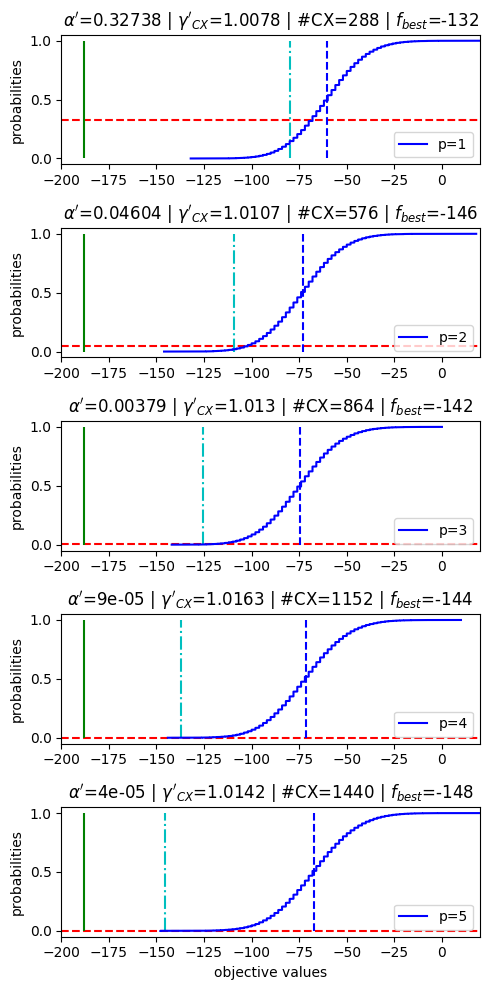

In [28]:
alpha_ = np.zeros(len(qcs))
best_val = np.zeros(len(qcs))
gamma_ = np.zeros(len(qcs))
mean = np.zeros(len(qcs))
gamma_cnot_ = np.zeros(len(qcs))

plt.subplots(5, 1, figsize=(5, 10))

for i in range(len(qcs)):

    cum_probs = np.cumsum(probs[i])
    rev_cum_probs = np.cumsum(probs[i][::-1])

    j = 1
    while np.sum(values[i][:j]@probs[i][:j])/cum_probs[j-1] < noise_free_exp_vals[i]:
        j += 1
    alpha_[i] = cum_probs[j-2]  # alpha' = fitted so CVaR matches expectation value
    best_val[i] = np.min(values[i])

    gamma_[i] = 1/alpha_[i]**2
    gamma_cnot_[i] = gamma_[i]**(1/num_cnots[i])

    mean[i] = values[i] @ probs[i]

    plt.subplot(5,1,i+1)

    plt.title(rf"$\alpha'$={np.round(alpha_[i], decimals=6)} | $\gamma'_{{CX}}$={np.round(gamma_cnot_[i], decimals=4)} | #CX={num_cnots[i]} | $f_{{best}}$={int(best_val[i])}")
    plt.hlines(alpha_[i], -200, 20, 'r', linestyles='--')
    plt.vlines(opt_val, 0, 1, 'g')
    plt.vlines(noise_free_exp_vals[i], 0, 1, 'c', linestyles='-.')
    plt.vlines(mean[i], 0, 1, 'b', linestyles='--')
    plt.plot(values[i], cum_probs, 'b', label=f'p={i+1}')
    plt.xlim(-200, 20)
    plt.legend(loc='lower right')
    plt.ylabel('probabilities')
    if i==4:
        plt.xlabel('objective values')
    
plt.tight_layout()
plt.savefig(f'results/figure_3_{backend.name}.pdf')
plt.show()

# Table 2

In [29]:
def npr(x, d=3):
    return np.round(x, decimals=d)


print('==============================')
print('global optimum:  ', opt_val)
# print('gamma_cnot:      ', npr(gamma_cnot, 4))
print('==============================')

for i in range(len(qcs)):
    print(f'p={i+1}')
    print('==============================')
    print('#CNOTs:          ', npr(num_cnots[i], 4))
    print('noise-free mean: ', npr(noise_free_exp_vals[i]))
    print('noisy mean:      ', npr(mean[i]))
    print('best sample:     ', best_val[i])
    # print('sqrt(gamma):     ', npr(sqrt_gamma[i]))
    # print('alpha:           ', npr(alpha[i], 8))
    print('alpha_prime:     ', npr(alpha_[i], 8))
    print('gamma_cnot_prime:', npr(gamma_cnot_[i], 4))
    print('==============================')

global optimum:   -188.0
p=1
#CNOTs:           288
noise-free mean:  -79.786
noisy mean:       -60.418
best sample:      -132.0
alpha_prime:      0.32738
gamma_cnot_prime: 1.0078
p=2
#CNOTs:           576
noise-free mean:  -109.353
noisy mean:       -73.011
best sample:      -146.0
alpha_prime:      0.04604
gamma_cnot_prime: 1.0107
p=3
#CNOTs:           864
noise-free mean:  -125.372
noisy mean:       -74.415
best sample:      -142.0
alpha_prime:      0.00379
gamma_cnot_prime: 1.013
p=4
#CNOTs:           1152
noise-free mean:  -137.225
noisy mean:       -71.556
best sample:      -144.0
alpha_prime:      9e-05
gamma_cnot_prime: 1.0163
p=5
#CNOTs:           1440
noise-free mean:  -145.541
noisy mean:       -67.191
best sample:      -148.0
alpha_prime:      4e-05
gamma_cnot_prime: 1.0142


# Figure 4

In [30]:
def bootstrap(values, N, alphas):
    samples = np.random.choice(values, size=int(N))
    sorted_samples = sorted(samples)
    ks = np.ceil(N*np.array(alphas))
    return [np.mean(sorted_samples[:(int(k)+1)]) for k in ks]

In [31]:
N = 100_000
M = 10_000
cvars = np.zeros((M, len(alpha_)))
for i in range(5):
    for j in range(M):
        cvar_sample = bootstrap(values[i], N, [alpha_[i]])
        cvars[j, i] = cvar_sample[0]

In [32]:
cvar_vars = np.zeros(5)
for i in range(5):
    cvar_vars[i] = np.var(cvars[:, i])

In [33]:
fit = np.polyfit(np.log(alpha_[:]), np.log(cvar_vars[:]), 1)
fit
a = np.exp(fit[1])
b = -fit[0]
(a, b)

(0.002206363433583952, 0.7168364820087756)

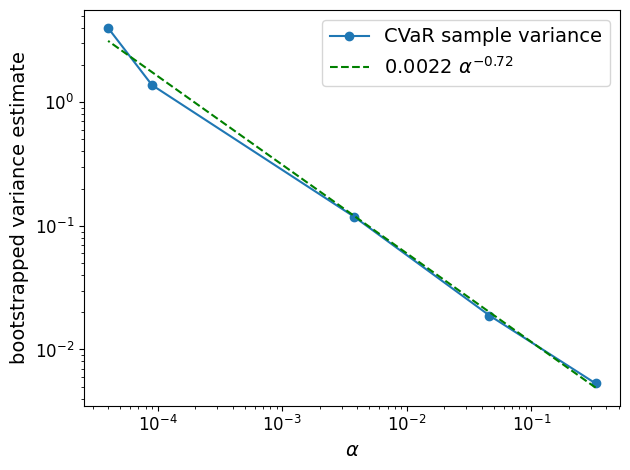

In [34]:
plt.loglog(alpha_, cvar_vars, 'o-', label='CVaR sample variance')
plt.plot(alpha_, a/np.array(alpha_)**b, 'g--', 
         label=rf'{np.round(a, decimals=4)} $\alpha^{{{-np.round(b, decimals=2)}}}$')
plt.legend(fontsize=14)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel('bootstrapped variance estimate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'results/figure_4_{backend.name}.pdf')
plt.show()